In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import requests
from bs4 import BeautifulSoup
import yfinance as yf

In [2]:
def get_historical_fundamentals(ticker, date):
    return {
        'P/E': np.random.random(),
        'P/B': np.random.random(),
        'ROE': np.random.random(),
        'Dividend Yield': np.random.random(),
        'Revenue Growth Rate': np.random.random(),
        'Net Income Growth Rate': np.random.random(),
        'EV/EBIT': np.random.random(),
        'FCF Growth Rate': np.random.random(),
        'EPS': np.random.random()
    }

In [3]:
url_spy = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
url_nasdaq = 'https://en.wikipedia.org/wiki/NASDAQ-100'
response_spy = requests.get(url_spy)
response_nasdaq = requests.get(url_nasdaq)
soup_spy = BeautifulSoup(response_spy.text, 'html.parser')
soup_nasdaq = BeautifulSoup(response_nasdaq.text, 'html.parser')
table_spy = soup_spy.find('table', {'class': 'wikitable sortable'})
table_nasdaq = soup_nasdaq.find('table', {'class': 'wikitable sortable'})
tickers_spy = [row.find_all('td')[0].text.strip() for row in table_spy.find_all('tr')[1:]]
tickers_nasdaq = [row.find_all('td')[1].text.strip() for row in table_nasdaq.find_all('tr')[1:]]
tickers = list(set(tickers_spy + tickers_nasdaq))

In [4]:
# Identify overlapping tickers
overlapping_tickers = set(tickers_spy).intersection(tickers_nasdaq)
print(f"Overlapping tickers between S&P 500 and NASDAQ-100: {len(overlapping_tickers)}")
print(overlapping_tickers)

Overlapping tickers between S&P 500 and NASDAQ-100: 85
{'META', 'AMD', 'PCAR', 'DLTR', 'PAYX', 'ILMN', 'ABNB', 'KDP', 'PYPL', 'HON', 'FTNT', 'ADP', 'KHC', 'LIN', 'LULU', 'DXCM', 'NXPI', 'KLAC', 'AEP', 'MRNA', 'INTC', 'MSFT', 'FANG', 'WBA', 'ADBE', 'CTSH', 'WBD', 'CDNS', 'ROP', 'CSX', 'ODFL', 'LRCX', 'CPRT', 'INTU', 'ROST', 'EXC', 'CHTR', 'CEG', 'VRSK', 'VRTX', 'AMAT', 'MDLZ', 'AAPL', 'EA', 'BIIB', 'NVDA', 'ADSK', 'AVGO', 'ANSS', 'IDXX', 'FAST', 'GILD', 'AMZN', 'ORLY', 'GOOGL', 'SNPS', 'MNST', 'ON', 'TTWO', 'GEHC', 'CDW', 'BKNG', 'CSCO', 'TSLA', 'CTAS', 'COST', 'CSGP', 'GOOG', 'TMUS', 'SBUX', 'PANW', 'CMCSA', 'ISRG', 'MU', 'MAR', 'BKR', 'ADI', 'TXN', 'XEL', 'NFLX', 'PEP', 'AMGN', 'MCHP', 'REGN', 'QCOM'}


In [5]:
data = yf.download(tickers, start='2020-01-01', end='2024-06-17')


[**********************76%%**********            ]  397 of 519 completed

$BF.B: possibly delisted; No price data found  (1d 2020-01-01 -> 2024-06-17)


[*********************100%%**********************]  519 of 519 completed

2 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2020-01-01 -> 2024-06-17)')


In [6]:
quarters = pd.date_range(start='2020-01-01', end='2024-06-17', freq='Q')
quarterly_returns = []
traded_stocks_per_quarter = []

In [7]:
for i in range(1, len(quarters)):
    quarter_start = quarters[i-1]
    quarter_end = quarters[i]
    
    fundamentals = {}
    for ticker in tickers:
        try:
            historical_fundamentals = get_historical_fundamentals(ticker, quarter_start)
            fundamentals[ticker] = historical_fundamentals
        except Exception as e:
            print(f"Could not download historical fundamentals for {ticker}: {e}")
            continue
    
    fundamentals_df = pd.DataFrame(fundamentals).T
    
    # Step 2: Data Preprocessing
    fundamentals_df = fundamentals_df.fillna(fundamentals_df.mean())
    
    scaler = StandardScaler()
    fundamentals_normalized = pd.DataFrame(scaler.fit_transform(fundamentals_df), index=fundamentals_df.index, columns=fundamentals_df.columns)
    
    # Step 3: Factor Scoring and Ranking
    def calculate_scores(df):
        scores = df.sum(axis=1)
        return scores.sort_values(ascending=False)
    
    scores = calculate_scores(fundamentals_normalized)
    ranked_stocks = scores.sort_values(ascending=False)
    
    top_n = 14
    selected_stocks = ranked_stocks.head(top_n).index.tolist()
    traded_stocks_per_quarter.append(selected_stocks)
    
    try:
        quarter_data = data['Adj Close'].loc[quarter_start:quarter_end, selected_stocks]
        
        print(f"Quarter: {quarter_start} to {quarter_end}")
        print(f"Selected Stocks: {selected_stocks}")
        print(f"Quarter Data Head:\n{quarter_data.head()}")
        
        if quarter_data.empty:
            print(f"No data available for selected stocks in the quarter ending {quarter_end}")
            quarterly_returns.append(0)
            continue
        
        quarter_data = quarter_data.dropna(axis=1, how='all')
        
        if not quarter_data.empty:
            returns = (quarter_data.iloc[-1] - quarter_data.iloc[0]) / quarter_data.iloc[0]
            quarterly_returns.append(returns.mean())
        else:
            print(f"All selected stocks have missing data for the quarter ending {quarter_end}")
            quarterly_returns.append(0)
    except Exception as e:
        print(f"Error calculating returns for the quarter ending {quarter_end}: {e}")
        quarterly_returns.append(0)

Quarter: 2020-03-31 00:00:00 to 2020-06-30 00:00:00
Selected Stocks: ['INCY', 'CMS', 'NEE', 'LDOS', 'TROW', 'CSX', 'XYL', 'MTCH', 'MELI', 'APD', 'HRL', 'EIX', 'CMCSA', 'PFE']
Quarter Data Head:
Ticker           INCY        CMS        NEE       LDOS       TROW        CSX  \
Date                                                                           
2020-03-31  73.230003  52.108784  54.473431  86.266869  82.704788  18.090378   
2020-04-01  74.180000  49.412434  49.404598  82.031174  79.503326  17.316881   
2020-04-02  77.070000  50.432430  51.265511  83.424240  82.272850  17.951466   
2020-04-03  78.589996  48.383556  50.176586  82.774796  80.621300  17.923054   
2020-04-06  85.110001  52.197475  53.090195  89.316566  86.981895  19.343760   

Ticker            XYL       MTCH        MELI         APD        HRL  \
Date                                                                  
2020-03-31  61.896458  66.040001  488.579987  181.734344  42.096107   
2020-04-01  56.802586  61.610001

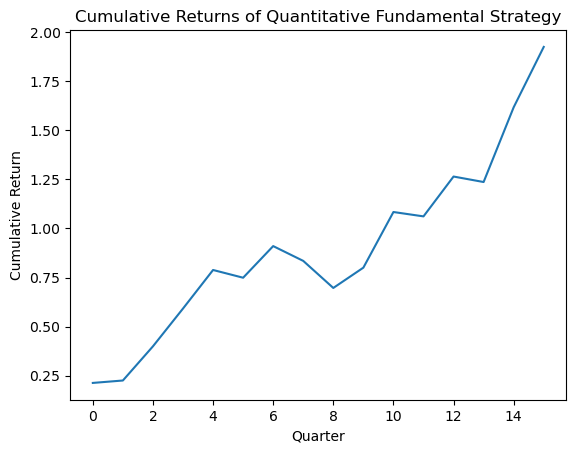

In [8]:
cumulative_returns = (1 + pd.Series(quarterly_returns)).cumprod() - 1
cumulative_returns.plot(title='Cumulative Returns of Quantitative Fundamental Strategy')
plt.xlabel('Quarter')
plt.ylabel('Cumulative Return')
plt.show()

In [9]:
# Step 5: Visualize the stocks being traded each quarter
for i, stocks in enumerate(traded_stocks_per_quarter):
    print(f"Quarter {i+1} ({quarters[i].date()}): {len(stocks)} stocks traded")
    print(stocks)

Quarter 1 (2020-03-31): 14 stocks traded
['INCY', 'CMS', 'NEE', 'LDOS', 'TROW', 'CSX', 'XYL', 'MTCH', 'MELI', 'APD', 'HRL', 'EIX', 'CMCSA', 'PFE']
Quarter 2 (2020-06-30): 14 stocks traded
['HII', 'DGX', 'REG', 'IRM', 'CCEP', 'ELV', 'ANSS', 'KHC', 'EL', 'CVS', 'WRB', 'WAT', 'SNA', 'SRE']
Quarter 3 (2020-09-30): 14 stocks traded
['ADBE', 'FTV', 'DLTR', 'AMZN', 'ODFL', 'MKTX', 'GEHC', 'UNP', 'GM', 'PARA', 'AVY', 'KO', 'MMC', 'CHTR']
Quarter 4 (2020-12-31): 14 stocks traded
['BA', 'T', 'COST', 'DDOG', 'CARR', 'LLY', 'RJF', 'MSCI', 'GFS', 'PLD', 'HII', 'OXY', 'ED', 'KMX']
Quarter 5 (2021-03-31): 14 stocks traded
['WDAY', 'FRT', 'AZN', 'CTVA', 'LKQ', 'CMS', 'JNJ', 'STLD', 'IQV', 'ADBE', 'HES', 'ZS', 'AIZ', 'SWK']
Quarter 6 (2021-06-30): 14 stocks traded
['HES', 'EOG', 'BXP', 'POOL', 'KVUE', 'AXP', 'DPZ', 'AVY', 'HLT', 'CMCSA', 'ACGL', 'NXPI', 'HD', 'QRVO']
Quarter 7 (2021-09-30): 14 stocks traded
['STLD', 'BSX', 'SYF', 'BDX', 'EXPD', 'JNPR', 'MO', 'CMS', 'HUM', 'UPS', 'KO', 'SBAC', 'BAX', 'C

In [10]:
latest_fundamentals = {}
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        
        # Retrieve latest financial data
        financials = stock.financials.T
        cashflow = stock.cashflow.T
        
        # Calculate additional fundamental metrics
        revenue_growth = (financials['Total Revenue'].pct_change(periods=4).iloc[-1] if 'Total Revenue' in financials else np.nan)
        net_income_growth = (financials['Net Income'].pct_change(periods=4).iloc[-1] if 'Net Income' in financials else np.nan)
        ev_ebit = info.get('enterpriseToEbitda', np.nan)
        fcf_growth = (cashflow['Free Cash Flow'].pct_change(periods=4).iloc[-1] if 'Free Cash Flow' in cashflow else np.nan)
        eps = info.get('trailingEps', np.nan)
        
        latest_fundamentals[ticker] = {
            'P/E': info.get('forwardPE', np.nan),
            'P/B': info.get('priceToBook', np.nan),
            'ROE': info.get('returnOnEquity', np.nan),
            'Dividend Yield': info.get('dividendYield', np.nan),
            'Revenue Growth Rate': revenue_growth,
            'Net Income Growth Rate': net_income_growth,
            'EV/EBIT': ev_ebit,
            'FCF Growth Rate': fcf_growth,
            'EPS': eps
        }
    except Exception as e:
        print(f"Could not download latest fundamentals for {ticker}: {e}")

In [12]:
latest_fundamentals_df = pd.DataFrame(latest_fundamentals).T
latest_fundamentals_df = latest_fundamentals_df.fillna(latest_fundamentals_df.mean())
latest_fundamentals_normalized = pd.DataFrame(scaler.fit_transform(latest_fundamentals_df), index=latest_fundamentals_df.index, columns=latest_fundamentals_df.columns)
latest_scores = calculate_scores(latest_fundamentals_normalized)
latest_ranked_stocks = latest_scores.sort_values(ascending=False)
latest_top_n = 10
latest_selected_stocks = latest_ranked_stocks.head(latest_top_n).index.tolist()

In [13]:
latest_selected_stocks

['IRM', 'AON', 'NVR', 'RVTY', 'DDOG', 'CRWD', 'INTC', 'CLX', 'MAS', 'CL']

In [14]:
latest_scores

IRM     23.236280
AON     21.416264
NVR     19.339839
RVTY    13.966568
DDOG    11.571468
          ...    
ALL    -12.853570
NCLH   -12.924476
KMX    -13.006322
WBD    -13.841591
TEAM   -17.475894
Length: 519, dtype: float64

In [15]:
latest_fundamentals_df

,P/E,P/B,ROE,Dividend Yield,Revenue Growth Rate,Net Income Growth Rate,EV/EBIT,FCF Growth Rate,EPS
TXT,12.494185,2.370068,0.133730,0.000900,-0.148505,-0.664495,11.204,-0.478009,4.68
AMD,27.661896,4.451962,0.020130,0.024019,-0.569533,1.915691,64.345,-0.306869,0.70
QRVO,14.410804,3.089915,-0.018860,0.024019,0.065208,-11.432169,16.303,0.579260,-0.72
K,15.312500,6.361571,0.212710,0.038100,-0.269270,-0.890679,14.439,0.529959,2.36
HAS,14.272942,8.394686,-0.742750,0.046200,0.092359,-1.149399,16.927,0.647298,-10.15
...,...,...,...,...,...,...,...,...,...
UPS,13.806583,6.785660,0.320450,0.048600,-0.269270,-0.890679,10.894,-0.006496,6.91
MKC,22.355050,3.520570,0.139480,0.024500,-0.159242,0.098149,18.612,-0.161701,2.62
BLK,16.755400,2.934557,0.151710,0.026000,-0.269270,-0.890679,17.080,-0.174304,39.34
DAL,6.718157,2.850736,0.575380,0.008100,-0.705502,-3.687134,6.690,-5.988606,7.80
